### Tutorial 5: Nanostring Dataset

In this tutorial, we show using the model on 20 slices of nanostring. Relevant data can be obtained from https://drive.google.com/drive/folders/141__9Q4zYK_6A4stKsOE5WikIHgxFkhk

**Import the relevant python analysis package**

In [10]:
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch
import scipy
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import stCAMBL
import os
#Please change this path to your local R environment path
os.environ['R_HOME'] = '/data3/wkcui/env/anaconda3/envs/stCAMBL/lib/R'

**Read data and perform stCAMBL analysis**

In [11]:
random_seed = 2050
stCAMBL.set_seed(random_seed)
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
root = '/data3/yfchen/stCAMBL/data/nanostring'
ids = [
    'fov1', 'fov2', 'fov3', 'fov4', 'fov5',
    'fov6', 'fov7', 'fov8', 'fov9', 'fov10',
    'fov11', 'fov12', 'fov13', 'fov14', 'fov15',
    'fov16', 'fov17', 'fov18', 'fov19', 'fov20'
]
dataset = ids[16]
adata = sc.read_h5ad(os.path.join(root, dataset, 'sampledata.h5ad'))
n_clusters = len(set(adata.obs['merge_cell_type']))
# add ground_truth
adata.obs['ground_truth'] = adata.obs['merge_cell_type']
adata.layers['count'] = adata.X
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]

sc.pp.scale(adata)
if scipy.sparse.issparse(adata.X):
    adata.X = adata.X
from sklearn.decomposition import PCA
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X
graph_dict = stCAMBL.graph_construction(adata, 12)
model = stCAMBL.stCAMBL(dataset, adata.obsm['X_pca'], graph_dict, device=device , rec_w=6, gcn_w=6, self_w=4, hsl_w=4, csl_w=1)
model.train_model(epochs=200)
stCAMBL_feat, defeat, _, _, _ = model.process()
adata.obsm['emb'] = stCAMBL_feat
radius = 50
tool = 'mclust' 
from stCAMBL.clust_func import clustering
clustering(adata, n_clusters, radius=radius, method=tool, refinement=True)
sub_adata = adata[~pd.isnull(adata.obs['merge_cell_type'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['merge_cell_type'], sub_adata.obs['domain'])
adata.uns['ARI'] = ARI
print('Dataset:', dataset)
print('ARI:', ARI)    


100%|██████████| 200/200 [00:46<00:00,  4.28it/s]


fitting ...
  |======================================================================| 100%
Dataset: fov17
ARI: 0.5481155777764808


**Draw cluster map and UMAP**

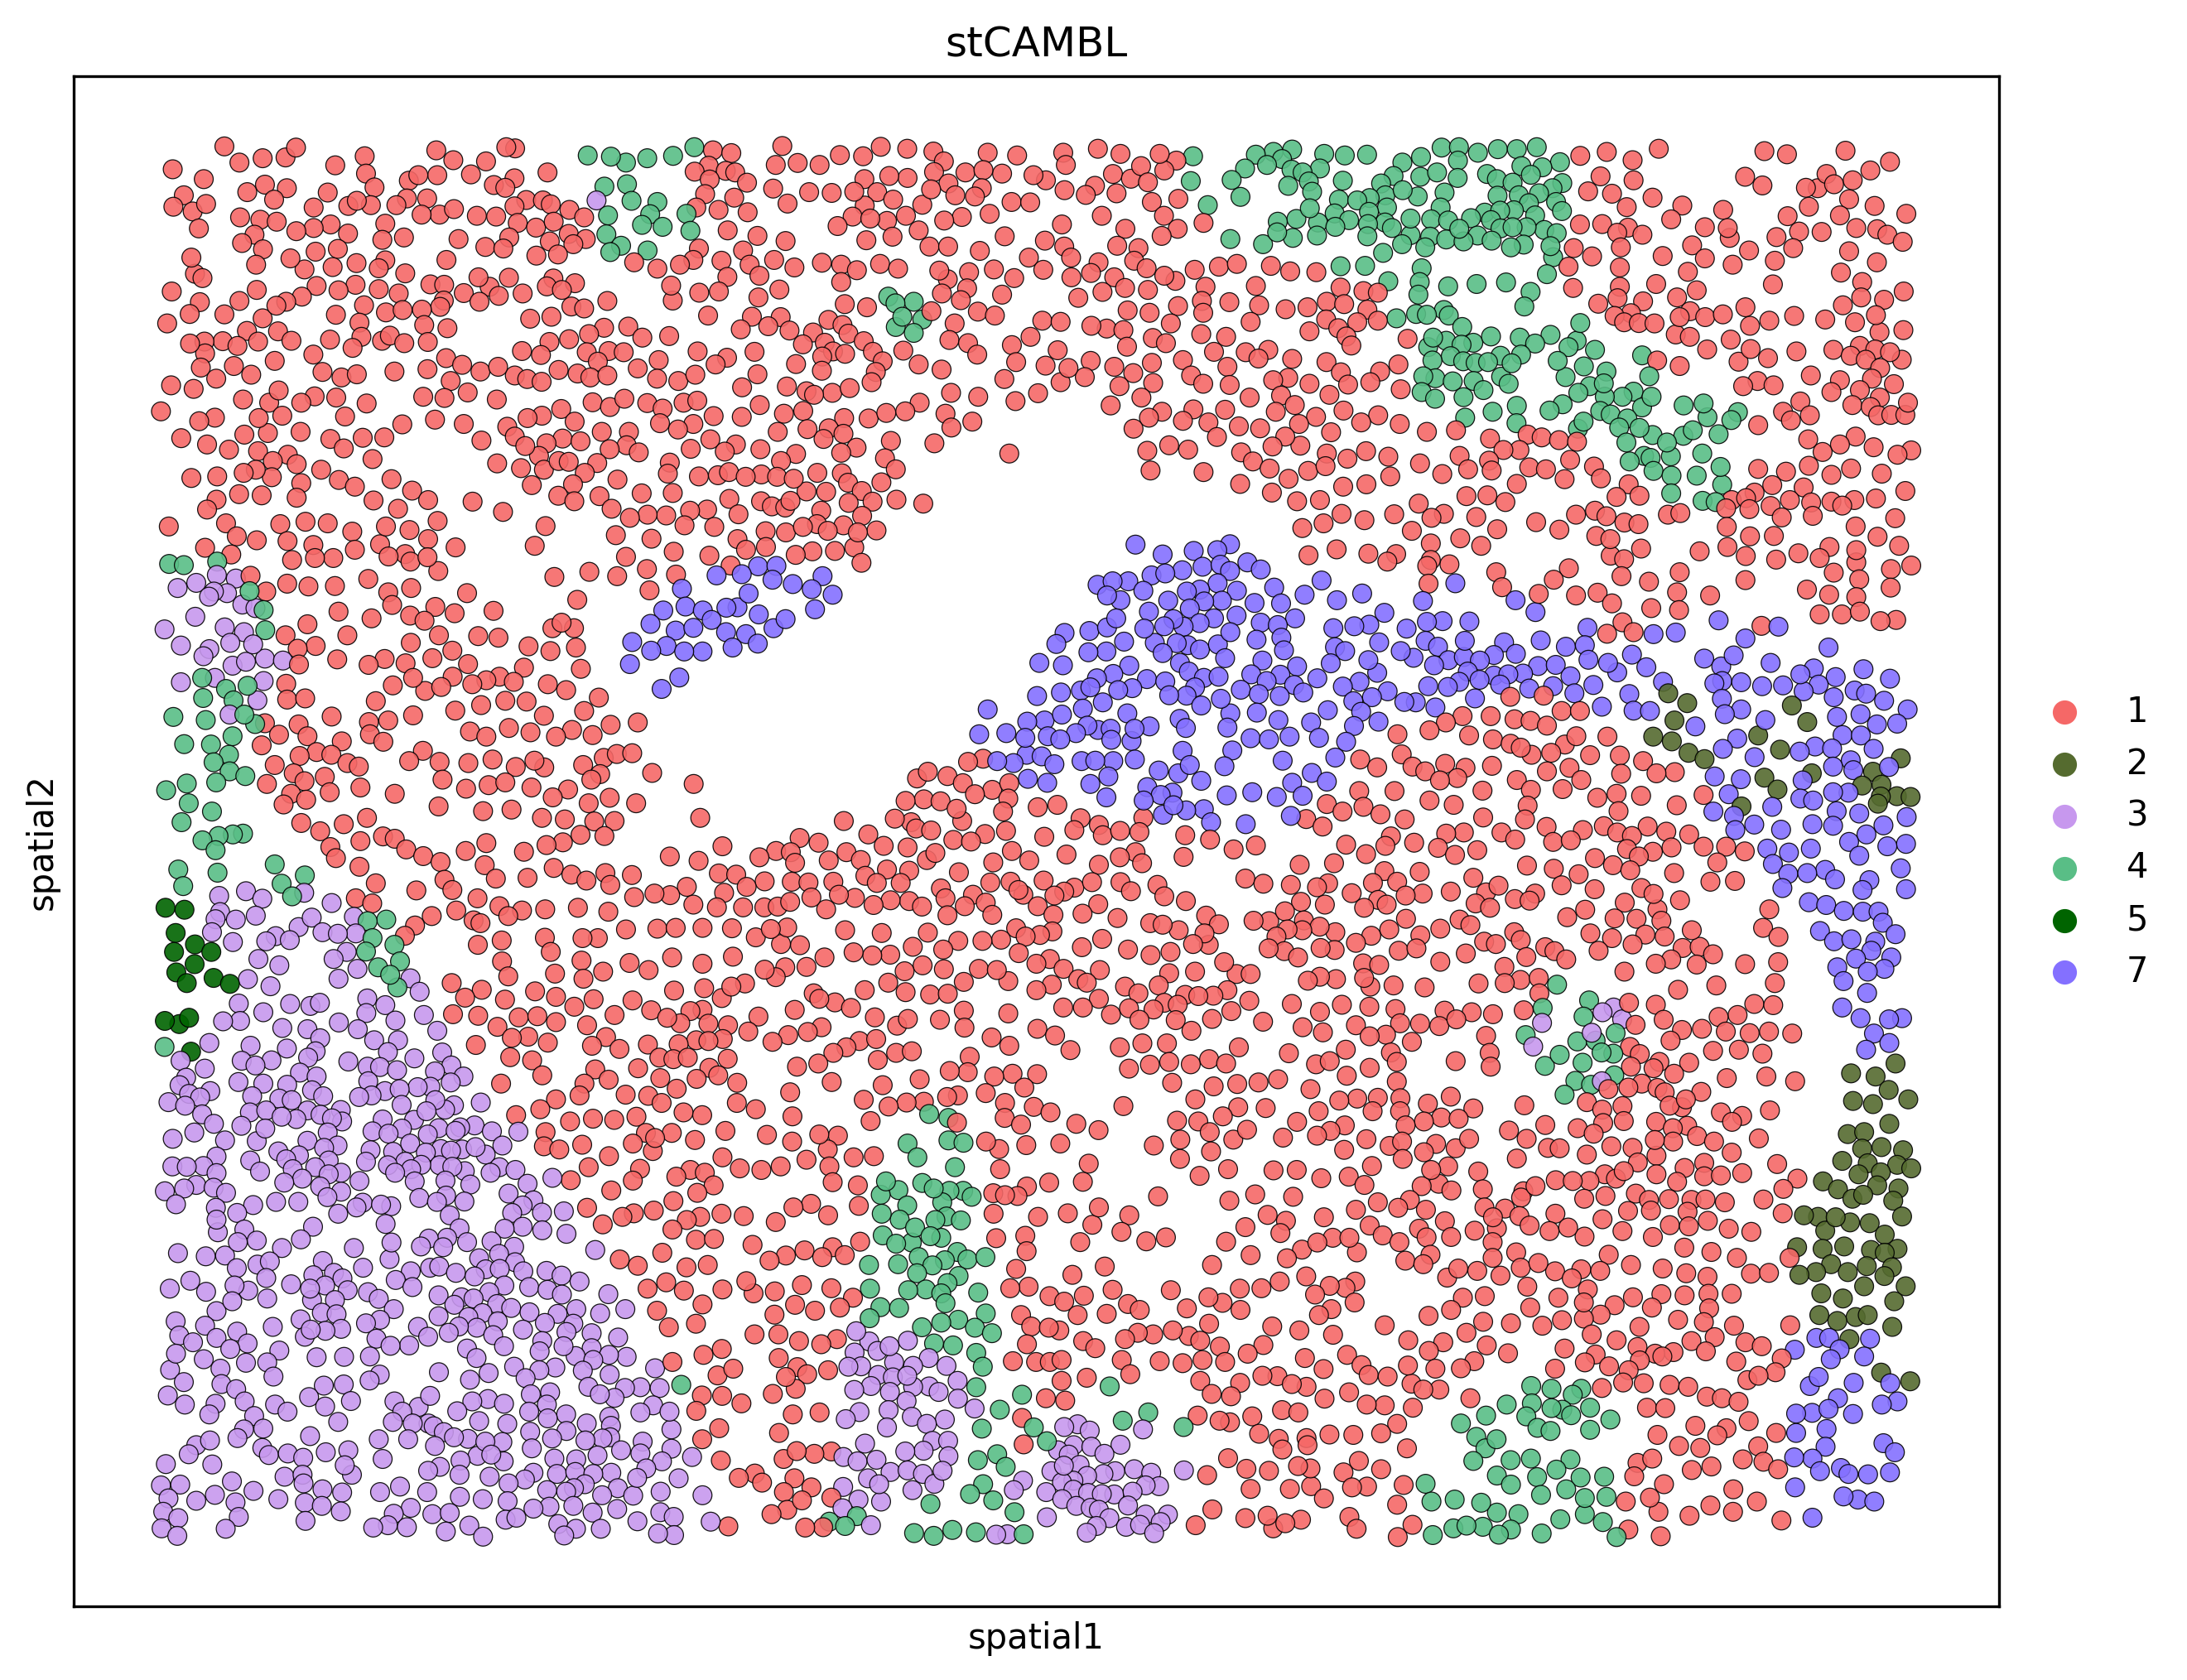

In [12]:
adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (10, 8) 
plt.rcParams['figure.dpi'] = 300  
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['font.family'] = 'DejaVu Sans' 
plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
           "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
           "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
          "#877F6C","#268785", '#82EF2D', '#B4EEB4']
ax = sc.pl.embedding(adata, basis="spatial",
                    color=['domain'],
                    s=120,
                    alpha=0.9, 
                    edgecolor='black',  
                    linewidth=0.3,  
                    show=True,
                    palette=plot_color,
                    title='stCAMBL',)

